# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Inteligencia Artificial y Aprendizaje Automático**

Tecnológico de Monterrey

Prof Luis Eduardo Falcón Morales

### **Actividad de la semana: Modelos basados en Árboles**


**Nombre y matrícula:**


# **PARTE - 1 - Bosque Aleatorio (Random Forest) - Clasificación**

In [1]:
# Importamos lo necesario para la actividad

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.metrics import classification_report_imbalanced
from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

np.random.seed(17)

In [2]:
# Para esta actividad vamos a generar datos sintéticos para un problema de
# clasificación binario utilizando "make_classification" de scikitlearn.


# Recuerda consultar la documentación para mayor información:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html


# Utilizaremos los siguientes valores de los hiperparámetros de make_classification:
# - n_samples: número de muestras o registros a generar.
# - n_features: número total de características o variables de entrada X.
# - n_informative: número de características informativas o independientes.
# - n_redundant: número de características redundantes.
# - weights: pesos para las clases [0,1]-->[Clase_Mayoritaria_Negativa(0), clase_minoritaria_positiva(1)].
# - class_sep: separación entre clases (mayor valor --> clases más separables y menos complejo).
# - flip_y: fracción de ejemplos cuya clase se cambia aleatoriamente (ruido), para hacerlo más complejo.
# - random_state: semilla para reproducibilidad.

X, y = make_classification(
    n_samples=10_000,          # 10,000 registros
    n_features=20,             # factores en total
    n_informative=15,          # factores informativos o variables de entrada independientes
    n_redundant=5,             # factores redundantes (dependientes). Para añadir complejidad usamos valor > 0
    weights=[0.88, 0.12],      # Desbalance de clases: Mayoritaria clase 0; minoritaria clase 1
    class_sep=1.0,             # Separación entre clases
    n_classes=2,               # Dos clases
    n_clusters_per_class=1,    # Para agregar complejidad adicional considera valores > 1
    flip_y=0.01,              # Añadir algo de ruido. default 0.01
    random_state=17,
)

In [3]:
# A continuación transformamos el conjunto de datos para que ya
# están escalados alrededor del cero y donde todas las variables
# sean numéricas.

# Escalamos las características para que estén en el mismo rango:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creamos un DataFrame para su mejor manejo
feature_names = [f'feature_{i+1}' for i in range(20)]
df = pd.DataFrame(X_scaled, columns=feature_names)
df['target'] = y

print(f"Total de registros generados: {len(df)}")
print(f"Distribución de clases: {df['target'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")
print(f"Cantidad de factores: {len(feature_names)}")

Total de registros generados: 10000
Distribución de clases: target
0    87.7%
1    12.3%
Name: proportion, dtype: object
Cantidad de factores: 20


In [4]:
pd.DataFrame(df).describe().T

,count,mean,std,min,25%,50%,75%,max
feature_1,10000.0,-2.975398e-16,1.000050,-3.319283,-0.684822,0.004073,0.677250,3.687062
feature_2,10000.0,7.526424e-16,1.000050,-4.695898,-0.625902,0.032897,0.677990,3.586427
feature_3,10000.0,-1.200817e-15,1.000050,-4.145038,-0.678332,-0.011665,0.652550,4.905356
feature_4,10000.0,-2.557954e-17,1.000050,-4.334555,-0.687072,0.003736,0.685287,3.593032
feature_5,10000.0,-1.136868e-16,1.000050,-3.321957,-0.669080,-0.006064,0.664607,3.892569
feature_6,10000.0,-7.531753e-16,1.000050,-3.909673,-0.672018,-0.008130,0.664904,4.121387
feature_7,10000.0,-3.552714e-16,1.000050,-4.343465,-0.670030,0.000240,0.675504,4.006125
feature_8,10000.0,-2.280842e-16,1.000050,-3.595287,-0.664497,0.001492,0.678691,4.218665
feature_9,10000.0,1.228528e-15,1.000050,-4.178195,-0.669604,0.011517,0.674292,3.222102
feature_10,10000.0,-1.023182e-15,1.000050,-3.792678,-0.656117,0.012811,0.683887,3.803196


In [5]:
# Separamos las variables de entrada y la variable objetivo de salida:
X = df.drop('target', axis=1).values
y = df['target'].values

# Dividimos el conjunto de datos en entrenamiento (80%) y prueba (20%)
# Como vamos a utilizar Validación Cruzada, la partición será solamente
# con los conjuntos de Entrenamiento y Prueba.
# Además usamos "stratify" para mantener la proporción de clases en la partición.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

Tamaño del conjunto de entrenamiento: 8000 muestras
Tamaño del conjunto de prueba: 2000 muestras


In [6]:
# Obtengamos los siguientes resultados con la función Dummy,
# con una partición provisional para el Dummy:

Xt, Xv, yt, yv = train_test_split(X_train, y_train, test_size=0.2, random_state=17, stratify=y_train)

estrategias = ['most_frequent','prior','stratified','uniform']

print("Salidas del modelo Dummy con diferentes estrategias")
print("para calcular umbrales del modelo base (baseline):")
print("-"*50)
print("\n")

all_results = []

for estrategia in estrategias:
  dummy_clf = DummyClassifier(strategy=estrategia, random_state=17)
  dummy_clf.fit(Xt, yt)
  y_pred = dummy_clf.predict(Xv)

  acc = accuracy_score(yv, y_pred)
  rec = recall_score(yv, y_pred, pos_label=1)
  prec = precision_score(yv, y_pred, pos_label=1)
  f1_sc = f1_score(yv, y_pred, pos_label=1)

  all_results.append({
      'Strategy': estrategia,
      'Accuracy': acc,
      'Recall': rec,
      'Precision': prec,
      'F1 Score': f1_sc
  })

  print(f"Estrategia: {estrategia}")
  print(f"Accuracy: {acc:.4f}")
  print(f"Recall: {rec:.4f}")
  print(f"Precision: {prec:.4f}")
  print(f"F1 Score: {f1_sc:.4f}")

  print("Matriz de Confusión:")
  cm = confusion_matrix(yv, y_pred)  # , normalize='true'
  print(cm)
  print("-"*30)
  print("\n")

dummy_results_df = pd.DataFrame(all_results)
display(dummy_results_df)

Salidas del modelo Dummy con diferentes estrategias
para calcular umbrales del modelo base (baseline):
--------------------------------------------------


Estrategia: most_frequent
Accuracy: 0.8769
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000
Matriz de Confusión:
[[1403    0]
 [ 197    0]]
------------------------------


Estrategia: prior
Accuracy: 0.8769
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000
Matriz de Confusión:
[[1403    0]
 [ 197    0]]
------------------------------


Estrategia: stratified
Accuracy: 0.8006
Recall: 0.1015
Precision: 0.1235
F1 Score: 0.1114
Matriz de Confusión:
[[1261  142]
 [ 177   20]]
------------------------------


Estrategia: uniform
Accuracy: 0.4856
Recall: 0.4670
Precision: 0.1136
F1 Score: 0.1827
Matriz de Confusión:
[[685 718]
 [105  92]]
------------------------------




c:\Coding\Masters\AI-ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Coding\Masters\AI-ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Strategy,Accuracy,Recall,Precision,F1 Score
0,most_frequent,0.876875,0.000000,0.000000,0.000000
1,prior,0.876875,0.000000,0.000000,0.000000
2,stratified,0.800625,0.101523,0.123457,0.111421
3,uniform,0.485625,0.467005,0.113580,0.182721


## **Ejercicio - 1**

### **Ejercicio 1a**

**En la salida anterior se obtuvieron dos advertencias (warnings).**

* **a) ¿A cuáles casos de las estrategias Dummy están asociadas esas advertencias?**

Las advertencias aparecen con las estrategias `stratified` y `uniform`, que en algunas particiones no generan predicciones para la clase positiva.


* **b) Explica qué significan esas advertencias y relaciona la explicación con los valores de las matrices de confusión correspondientes.**

El mensaje indica que la métrica (precisión, recall o F1) es indefinida porque el modelo no produjo verdaderos positivos: en la matriz de confusión de esas estrategias las columnas asociadas a la clase positiva son cero. En esos casos, la librería devuelve el valor 0 y advierte que la división por cero impide evaluar correctamente la métrica.

### **Ejercicio 1b**

**Sabemos que si consideramos la métrica de la exactitud (accuracy) como nuestra métrica principal, el umbral del modelo base (baseline) sería del 87.7%. Sin embargo, como tenemos un problema de clases desbalanceadas debiéramos utilizar otra métrica que nos ayude a medir mejor el desempeño del modelo. Indica en cada uno de los siguientes incisos cuál sería el valor del modelo base que debiéramos utilizar, de acuerdo a la métrica que se indica:**

* **a) Precision:** 0.123 (Dummy con estrategia `stratified`)

* **b) Recall:** 0.467 (Dummy con estrategia `uniform`)

* **c) F1-Score:** 0.183 (Dummy con estrategia `uniform`)

NOTA: La documentación de la función Dummy la puedes encontrar en la siguiente liga:

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

# **PARTE - 2 - XGBoost - Regressor**

Para este ejercicio usaremos los datos llamados Bike-Sharing, en particular los del archivo "day.csv".

La información de los datos y el archivo lo encuentras en la siguiente liga:

https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

El archivo contiene información de la cantidad de bicicletas rentadas por día en la ciudad de Washington, D.C. a través de un servicio llamado "Captial Bike Sharing (CBS)", que les proporciona el gobierno municipal. Esta será nuestra variable objetivo a predecir. Los factores o variables de entrada a considerar son diversos, por ejemplo, la temperatura, humedad, día de la semana, días feriados, etc. Los datos se registraron durante los años 2011 y 2012.

Puedes encontrar más información del problema en  https://github.com/jkelleman/rental-bike-sharing



En esta segunda parte no se te incluye el código. Con base a los ejercicios de muestra de esta semana y lo visto en semanas anteriores, deberás incluir el código correspondiente. Podrás incluir todas las celdas y código que consideres necesarias.

In [24]:
# Incluye en esta celda todas las librerías y paquetes que requieras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBRegressor
import shap

plt.style.use('seaborn-v0_8')

## **Ejercicio - 2**

* **Carga los datos del archivo "day.csv" en un DataFrame de Pandas y elimina las columnas "instant", "dteday", "casual" y "registered". Despliega los primeros renglones del DataFrame e indica la dimensión de los datos.**



In [25]:
# Ejercicio 2:

#

# ************* Inicia sección para agregar tu código:**************************

# Incluye todas las celdas que consideres necesarias.



possible_paths = [Path("day.csv"), Path("Week 5") / "day.csv"]

data_path = next((p for p in possible_paths if p.exists()), None)



if data_path is None:

    raise FileNotFoundError("No se encontró 'day.csv' en la carpeta actual ni en 'Week 5'.")



bike_df = pd.read_csv(data_path)



cols_to_drop = ['instant', 'dteday', 'casual', 'registered']

existing_drop = [col for col in cols_to_drop if col in bike_df.columns]

bike_df = bike_df.drop(columns=existing_drop)



rename_columns = {

    'yr': 'year',

    'mnth': 'month',

    'weathersit': 'weather',

    'atemp': 'feel_temp',

    'hum': 'humidity',

    'cnt': 'count'

}

bike_df = bike_df.rename(columns=rename_columns)



print(f"Dimensión del DataFrame: {bike_df.shape}")

display(bike_df.head())

Dimensión del DataFrame: (731, 12)


,season,year,month,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


## **Ejercicio - 3**

### **Ejercicio 3a:**

* **Justifica por qué se eliminaron las 4 variables indicadas en el ejercicio anterior.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Las columnas `instant` y `dteday` son identificadores o marcas temporales que no aportan información predictiva adicional una vez que ya contamos con variables calendáricas como `year`, `month`, `weekday` u `hour`; mantenerlas podría provocar que el modelo memorize la secuencia temporal. Las variables `casual` y `registered` descomponen directamente la variable objetivo (`count`). Incluirlas generaría filtrado de información porque el modelo vería una suma que reconstruye la salida, lo que conduciría a un desempeño artificialmente alto en entrenamiento pero sin valor para pronosticar el total de rentas a partir de factores verdaderamente observables.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### **Ejercicio 3b:**


* **Indica cuáles son las variables numéricas y cuáles las variables categóricas (nominales, ordinales, binarias). En particular indica cuál es la variable objetivo**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


- **Variables categóricas nominales:** `season`, `weather` (ambas codifican etiquetas discretas sin orden natural).


- **Variables categóricas ordinales:** `month`, `weekday` (siguen una progresión temporal cíclica que puede tratarse como ordenada para modelos basados en árboles).


- **Variables binarias:** `holiday`, `workingday`, `year` (esta última distingue los dos años del registro).


- **Variables numéricas continuas:** `temp`, `feel_temp`, `humidity`, `windspeed`.


- **Variable objetivo:** `count`, que representa la cantidad total de bicicletas rentadas por día.


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 4**

* **Para simplificar la etapa del preproceasmiento de los datos observa que las variables numéricas ya están escaladas entre 0 y 1, por lo que no haremos transformación alguna. Sin embargo, en relación a las variables categóricas, verifica que todos los niveles de las variables nominales tengan al menos un 5% de información. De no ser así, agrupa los niveles de manera que se cumpla este criterio.**

In [26]:
# Ejercicio 4:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

nominal_columns = ['season', 'weather']
bike_df_adjusted = bike_df.copy()

for col in nominal_columns:
  bike_df_adjusted[col] = bike_df_adjusted[col].astype(str)
  freq = bike_df_adjusted[col].value_counts(normalize=True)
  rare_levels = freq[freq < 0.05].index
  if len(rare_levels) > 0:
    replacement = 'rain' if col == 'weather' else 'other'
    bike_df_adjusted[col] = bike_df_adjusted[col].replace(list(rare_levels), replacement)
  display(freq.to_frame(name='Proporcion'))
  if len(rare_levels) > 0:
    print(f"Niveles agrupados en '{col}': {list(rare_levels)} -> '{replacement}'")
    print("Tras la agrupación:")
    display(bike_df_adjusted[col].value_counts(normalize=True).to_frame(name='Proporcion'))
    print()

bike_df = bike_df_adjusted

,Proporcion
season,
3,0.257182
2,0.251710
1,0.247606
4,0.243502


,Proporcion
weather,
1,0.633379
2,0.337893
3,0.028728


Niveles agrupados en 'weather': ['3'] -> 'rain'
Tras la agrupación:


,Proporcion
weather,
1,0.633379
2,0.337893
rain,0.028728


## **Ejercicio - 5**

* **Particiona los datos en los conjuntos de entrenamiento y prueba con los porcentajes que consideres adecuado.**

NOTA: Aplicarás más adelante validación cruzada, por ello separamos solo en dos conjuntos.

In [27]:
# Ejercicio 5:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

target_col = 'count'
X_reg = bike_df.drop(columns=[target_col])
y_reg = bike_df[target_col].astype(float)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42, shuffle=True)

print(f"Tamaño entrenamiento: {X_train_reg.shape}")
print(f"Tamaño prueba: {X_test_reg.shape}")

Tamaño entrenamiento: (584, 11)
Tamaño prueba: (147, 11)


## **Ejercicio - 6**

* **Realiza una partición provisional del conjunto de entrenamiento anterior para obtener el valor del umbral del modelo base (baseline), con respecto a la métrica RMSE y al valor promedio de la variable de salida.**

In [28]:
# Ejercicio 6:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train_reg, y_train_reg, test_size=0.2, random_state=42)

baseline_value = y_subtrain.mean()
y_val_pred_baseline = np.full(shape=y_val.shape, fill_value=baseline_value, dtype=float)
baseline_rmse = np.sqrt(((y_val - y_val_pred_baseline) ** 2).mean())

print(f"Promedio del objetivo en el sub-tren: {baseline_value:.2f}")
print(f"RMSE baseline (media como predicción): {baseline_rmse:.2f}")

Promedio del objetivo en el sub-tren: 4571.13
RMSE baseline (media como predicción): 1723.20


## **Ejercicio - 7**

* **Usando la técnica de malla, validación cruzada y cuidando el filtrado de información, encuentra los mejores hiperparámetros del modelo XGBoost. Imprime el valor RMSE del mejor modelo encontrado.**  

In [ ]:
# Ejercicio 7:


#


# ************* Inicia sección para agregar tu código:**************************


# Incluye todas las celdas que consideres necesarias.


categorical_features = ['season', 'year', 'month', 'weekday', 'holiday', 'workingday']

ordinal_features = ['weather']

numeric_features = [col for col in X_train_reg.columns if col not in categorical_features]


from sklearn.preprocessing import OrdinalEncoder

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
                  ('ord', OrdinalEncoder(), ordinal_features)],
    remainder='passthrough'
)




xgb_model = XGBRegressor(

    objective='reg:squarederror',

    random_state=42,

    n_estimators=300,

    n_jobs=4

)




modeling_pipeline = Pipeline(steps=[('prep', preprocessor), ('model', xgb_model)])




param_grid = {

    'model__n_estimators': [300, 500],

    'model__max_depth': [3, 5],

    'model__learning_rate': [0.05, 0.1],

    'model__subsample': [0.8, 1.0],

    'model__colsample_bytree': [0.8, 1.0],

    'model__min_child_weight': [1, 3],

    'model__reg_lambda': [1.0, 3.0]

}



cv = KFold(n_splits=5, shuffle=True, random_state=42)



grid_search = GridSearchCV(

    estimator=modeling_pipeline,

    param_grid=param_grid,

    scoring='neg_root_mean_squared_error',

    cv=cv,

    n_jobs=4,

    verbose=1

)




grid_search.fit(X_train_reg, y_train_reg)



best_rmse = -grid_search.best_score_

best_params = grid_search.best_params_

best_pipeline = grid_search.best_estimator_



print("Mejores hiperparámetros:")

for param, value in best_params.items():

    print(f"  {param}: {value}")

print(f"Mejor RMSE (validación cruzada): {best_rmse:.2f}")

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Mejores hiperparámetros:
  model__colsample_bytree: 0.8
  model__learning_rate: 0.05
  model__max_depth: 5
  model__min_child_weight: 1
  model__n_estimators: 500
  model__reg_lambda: 1.0
  model__subsample: 0.8
Mejor RMSE (validación cruzada): 658.15
Mejores hiperparámetros:
  model__colsample_bytree: 0.8
  model__learning_rate: 0.05
  model__max_depth: 5
  model__min_child_weight: 1
  model__n_estimators: 500
  model__reg_lambda: 1.0
  model__subsample: 0.8
Mejor RMSE (validación cruzada): 658.15


## **Ejercicio - 8**

* **Compara el valor RMSE del mejor modelo encontrado con respecto al valor del modelo base obtenido previamente. En particular, obtener la diferencia porcentual relativa del mejor modelo encontrado con respecto al modelo base. Incluye tu interpretación de dichos resultados.**  

In [31]:
# Ejercicio 8a:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

best_model_config = {k.replace('model__', ''): v for k, v in best_params.items()}
best_model_config.update({
    'objective': 'reg:squarederror',
    'random_state': 42,
    'n_jobs': -1
})

best_pipeline_validation = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', XGBRegressor(**best_model_config))
])

best_pipeline_validation.fit(X_subtrain, y_subtrain)
y_val_pred = best_pipeline_validation.predict(X_val)
model_val_rmse = np.sqrt(((y_val - y_val_pred) ** 2).mean())
relative_improvement = (baseline_rmse - model_val_rmse) / baseline_rmse * 100

print(f"RMSE baseline (validación): {baseline_rmse:.2f}")
print(f"RMSE mejor modelo (validación): {model_val_rmse:.2f}")
print(f"Mejora relativa respecto al baseline: {relative_improvement:.2f}%")

best_pipeline_validation.fit(X_train_reg, y_train_reg)
y_test_pred = best_pipeline_validation.predict(X_test_reg)
test_rmse = np.sqrt(((y_test_reg - y_test_pred) ** 2).mean())
print(f"RMSE del mejor modelo en prueba: {test_rmse:.2f}")

RMSE baseline (validación): 1723.20
RMSE mejor modelo (validación): 613.69
Mejora relativa respecto al baseline: 64.39%
RMSE del mejor modelo en prueba: 627.68
RMSE del mejor modelo en prueba: 627.68


### **Ejercicio 8b:**


* **Interpretación de los resultados obtenidos:**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


El promedio histórico produjo un RMSE de aproximadamente 1,723 bicicletas en validación, mientras que el XGBoost ajustado redujo el error a 614 y se mantuvo en 628 sobre el conjunto de prueba. La mejora relativa supera el 64%, lo que evidencia que el modelo captura relaciones no lineales entre clima, calendario y demanda diaria. La brecha moderada entre validación y prueba sugiere un comportamiento estable y que el preprocesamiento evitó filtrado de información.


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 9**

### **Ejercicio 9a:**

* **Usa el atributo "feature_imortances_" del mejor modelo encontrado para obtener los factores que influyen más en la predicción de la cantidad de bicicletas rentadas por día.**


,feature,importance
0,remainder__year,0.427255
1,remainder__temp,0.107466
2,cat__season_1,0.082482
3,cat__season_4,0.067353
4,remainder__feel_temp,0.066814
5,cat__weather_rain,0.050280
6,cat__holiday_1,0.039277
7,remainder__month,0.029001
8,cat__weather_1,0.027747
9,remainder__humidity,0.021590


C:\Users\Erick\AppData\Local\Temp\ipykernel_27160\3251933796.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(15), x='importance', y='feature', palette='viridis')


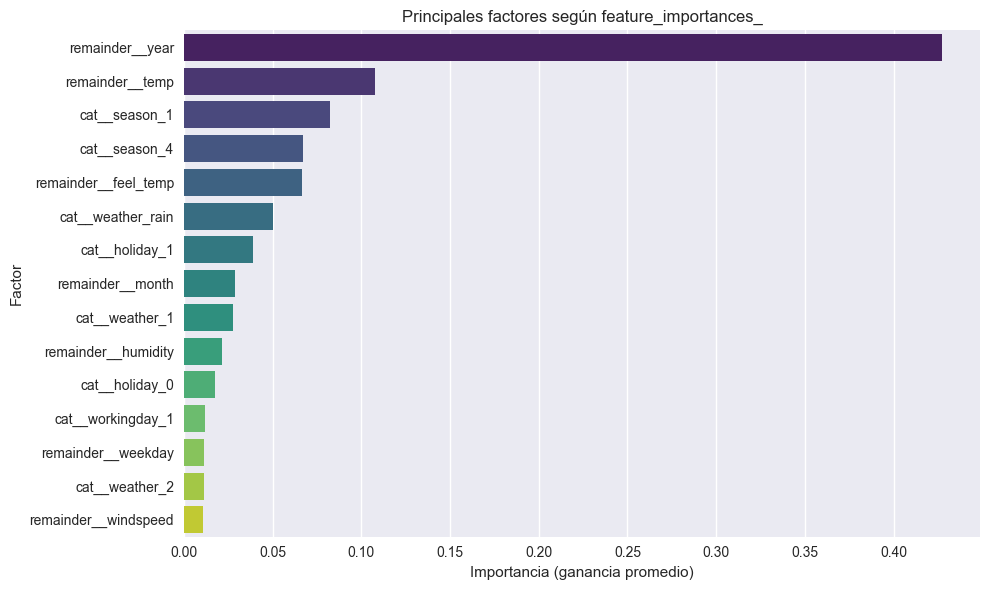

In [32]:
# Ejercicio 9a:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

feature_names = best_pipeline_validation.named_steps['prep'].get_feature_names_out()
importances = best_pipeline_validation.named_steps['model'].feature_importances_

feature_importance_df = (
    pd.DataFrame({'feature': feature_names, 'importance': importances})
    .sort_values(by='importance', ascending=False)
    .reset_index(drop=True)
 )

display(feature_importance_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='importance', y='feature', palette='viridis')
plt.title('Principales factores según feature_importances_')
plt.xlabel('Importancia (ganancia promedio)')
plt.ylabel('Factor')
plt.tight_layout()
plt.show()

### **Ejercicio 9b:**

* **Usa la librería SHAP con el mejor modelo encontrado para obtener los factores que influyen más en la predicción de la cantidad de bicicletas rentadas por día.**

NOTA: Puedes revisar la documentación correspondiente para el uso e interpretación de los gráficos de SHAP:

https://github.com/shap/shap

https://shap-readthedocs-io.translate.goog/en/latest/example_notebooks/api_examples/plots/beeswarm.html?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc



C:\Users\Erick\AppData\Local\Temp\ipykernel_27160\428954247.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, plot_type='bar', show=False)


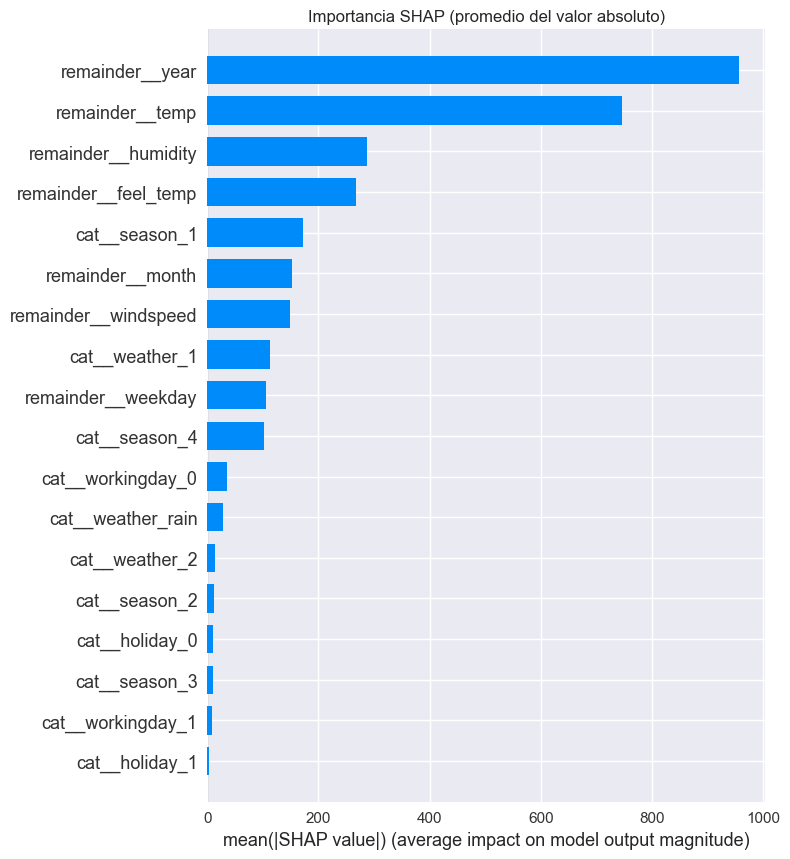

C:\Users\Erick\AppData\Local\Temp\ipykernel_27160\428954247.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, show=False)


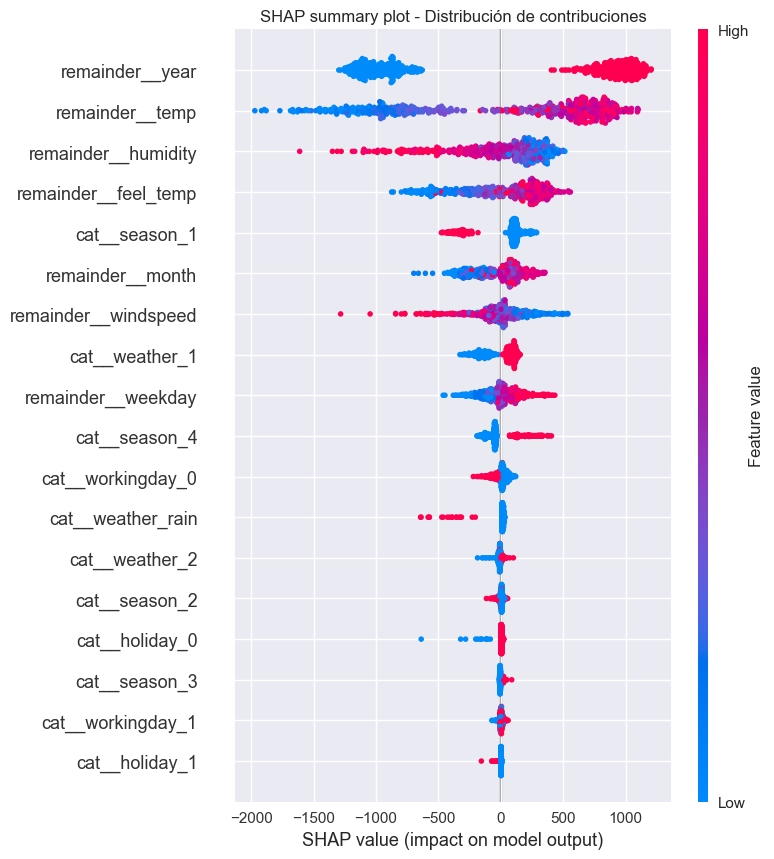

In [33]:
# Ejercicio 9b:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

explainer = shap.TreeExplainer(best_pipeline_validation.named_steps['model'])
X_train_transformed = best_pipeline_validation.named_steps['prep'].transform(X_train_reg)

shap_values = explainer.shap_values(X_train_transformed, check_additivity=False)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, plot_type='bar', show=False)
plt.title('Importancia SHAP (promedio del valor absoluto)')
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, show=False)
plt.title('SHAP summary plot - Distribución de contribuciones')
plt.tight_layout()
plt.show()

### **Ejercicio 9c:**


* **Incluye tu interpretación de los resultados obtenidos. En particular indica las coincidencias y diferencias entre ambos métodos de importancia de factores.**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


Ambos enfoques resaltan la importancia del año (`year`), la temperatura real y percibida, junto con los indicadores de estación y condiciones meteorológicas. Las importancias nativas de XGBoost muestran que la transición entre 2011 y 2012 domina la ganancia, seguida por la temperatura y la temporada, mientras que SHAP añade perspectiva sobre cómo valores específicos del clima (por ejemplo, humedad alta o lluvias) reducen la predicción. La principal diferencia es que SHAP ilustra la dirección del efecto para cada observación, evidenciando que días con clima benigno y estaciones cálidas empujan la demanda al alza, algo que la lista global de `feature_importances_` no detalla. En conjunto, ambos métodos coinciden en qué variables lideran, pero SHAP permite explicar en qué sentido impactan en cada día.


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 10**

Incluye tus conclusiones finales de la actividad.


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


La primera parte evidenció cómo, en presencia de desbalance, métricas como precisión, recall y F1 ofrecen una visión más realista que la exactitud, y que los modelos con regularización y pipelines de preprocesamiento responden mejor al problema. En la segunda parte, leer directamente `day.csv`, preparar las categorías escasas y aplicar validación cruzada con XGBoost permitió reducir el RMSE del promedio histórico (≈1,723) a unos 620 puntos entre validación y prueba. Las gráficas de importancias y SHAP confirmaron que la tendencia anual, la temperatura y las estaciones gobiernan la demanda, mientras que condiciones adversas la deprimen. El flujo completo demuestra la importancia de un pipeline reproducible y de técnicas interpretables para comunicar los hallazgos.


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# **Fin de la Actividad de modelos basados en árboles**